------------
# Importing Necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras
import tensorflow as tf
import pickle

from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from ipynb.fs.full.PreProcessing import get_moving_diff, rescaling, get_static_features

In [3]:
print(device_lib.list_local_devices())
config = tf.ConfigProto( device_count = {'GPU': 1} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15899080260373340960
]


---------------
# Loading Data into System

In [4]:
x_lstm_train = np.load(os.path.join('data', 'x_lstm_train.npy'))
x_lstm_test = np.load(os.path.join('data', 'x_lstm_test.npy'))

x_static_train = np.load(os.path.join('data', 'x_static_train.npy'))
x_static_test = np.load(os.path.join('data', 'x_static_test.npy'))

y_train = np.load(os.path.join('data', 'y_train.npy'))
y_test = np.load(os.path.join('data', 'y_test.npy'))

In [5]:
print(x_lstm_train.shape, x_lstm_test.shape)
print(x_static_train.shape, x_static_test.shape)
print(y_train.shape, y_test.shape)

(35776, 120) (8944, 120)
(35776, 9) (8944, 9)
(35776, 6) (8944, 6)


# Re-Structuring the data

In [6]:
x_lstm_train = np.expand_dims(x_lstm_train, axis=-1)
x_lstm_test = np.expand_dims(x_lstm_test, axis=-1)

x_static_train = np.expand_dims(x_static_train, axis=-1)
x_static_test = np.expand_dims(x_static_test, axis=-1)

In [7]:
print(x_lstm_train.shape, x_lstm_test.shape)
print(x_static_train.shape, x_static_test.shape)
print(y_train.shape, y_test.shape)

(35776, 120, 1) (8944, 120, 1)
(35776, 9, 1) (8944, 9, 1)
(35776, 6) (8944, 6)


# Model Creation

In [8]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [9]:
# 32, 16, 30 
model = keras.Sequential()

lstm_input = layers.Input(shape=(x_lstm_train.shape[1], x_lstm_train.shape[2]))

lstm_stack_1, lstm_stack_1_c = layers.GRU(120, return_sequences=True, return_state=True)(lstm_input)
drop_lstm_1 = layers.Dropout(0.05)(lstm_stack_1)

lstm_stack_2, lstm_stack_2_c = layers.GRU(120, return_sequences=True, return_state=True)(drop_lstm_1)

drop_2 = layers.Dropout(0.05)(lstm_stack_2_c)
dense_2 = layers.Dense(48)(drop_2)
drop_4 = layers.Dropout(0.02)(dense_2)

output = layers.Dense(6)(drop_4)


model = models.Model(inputs=lstm_input, outputs=output)
model.summary()
model.compile(
    loss='mse', 
    optimizer='adam', 
    metrics=[r_square,'mae']
)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 1)]          0         
_________________________________________________________________
gru (GRU)                    [(None, 120, 120), (None, 43920     
_________________________________________________________________
dropout (Dropout)            (None, 120, 120)          0         
_________________________________________________________________
gru_1 (GRU)                  [(None, 120, 120), (None, 86760     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 48)                5808      
_____________________________________________

In [11]:
filepath = "model_gru_stacked-{epoch:03d}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='r_square', verbose=1,
    save_best_only=False, save_weights_only = True, mode='auto', period=1)

history = model.fit(
    x_lstm_train, y_train,
    epochs=5,
    batch_size=48,
    verbose=1,
    validation_data=(x_lstm_test, y_test),
    shuffle=True,
    callbacks=[checkpoint]
)

Train on 35776 samples, validate on 8944 samples
Epoch 1/5
35760/35776 [============================>.] - ETA: 0s - loss: 9.2315e-04 - r_square: 0.0738 - mean_absolute_error: 0.0170
Epoch 00001: saving model to model_gru_stacked-001.h5
35776/35776 [==============================] - 595s 17ms/sample - loss: 9.2303e-04 - r_square: 0.0739 - mean_absolute_error: 0.0170 - val_loss: 6.3019e-04 - val_r_square: 0.1113 - val_mean_absolute_error: 0.0154
Epoch 2/5
35760/35776 [============================>.] - ETA: 0s - loss: 9.1435e-04 - r_square: 0.0816 - mean_absolute_error: 0.0169
Epoch 00002: saving model to model_gru_stacked-002.h5
35776/35776 [==============================] - 657s 18ms/sample - loss: 9.1415e-04 - r_square: 0.0818 - mean_absolute_error: 0.0169 - val_loss: 6.4753e-04 - val_r_square: 0.0868 - val_mean_absolute_error: 0.0157
Epoch 3/5
35760/35776 [============================>.] - ETA: 0s - loss: 9.2043e-04 - r_square: 0.0867 - mean_absolute_error: 0.0169
Epoch 00003: saving 

dict_keys(['loss', 'r_square', 'mean_absolute_error', 'val_loss', 'val_r_square', 'val_mean_absolute_error'])


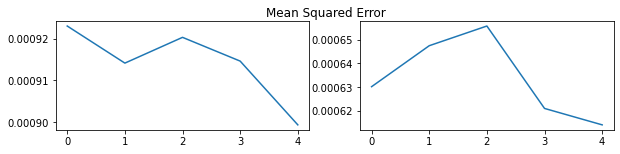

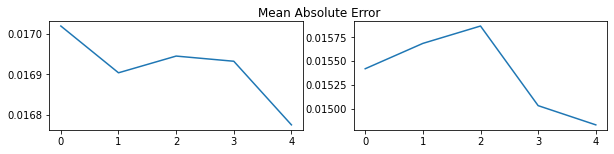

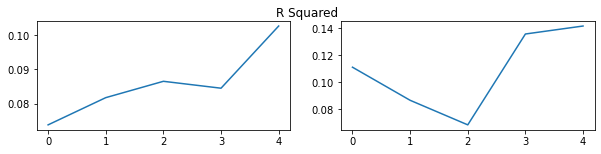

In [12]:
print(history.history.keys())

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2))
fig1.suptitle('Mean Squared Error')
ax1.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2))
fig2.suptitle('Mean Absolute Error')
ax1.plot(history.history['mean_absolute_error'])
ax2.plot(history.history['val_mean_absolute_error'])

fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2))
fig3.suptitle('R Squared')
ax1.plot(history.history['r_square'])
ax2.plot(history.history['val_r_square'])

In [ ]:
model.save(os.path.join('data','model_gru_stacked.h5'))

# Testing Prediction sequence

In [13]:
cgm_df = pd.read_csv(os.path.join('data','CGMData.csv')).T

In [14]:
testing_data = cgm_df.T.iloc[:,-400:-1].to_numpy()
testing_data

array([[143., 145., 146., 146., 147., 149., 150., 155., 163., 167., 169.,
        170., 171., 173., 180., 187., 190., 182., 177., 173., 161., 153.,
        143., 140., 141., 139., 140., 142., 130., 110., 110., 112., 117.,
        118., 116., 115., 114., 114., 114., 114., 115., 115., 116., 117.,
        118., 119., 119., 120., 120., 121., 121., 120., 120., 120., 122.,
        123., 123., 123., 122., 123., 124., 125., 126., 126., 125., 124.,
        123., 123., 123., 122., 120., 117., 116., 116., 117., 118., 118.,
        119., 120., 121., 122., 124., 124., 124., 125., 125., 125., 125.,
        124., 122., 121., 119., 118., 119., 123., 132., 139., 142., 144.,
        146., 148., 152., 156., 158., 159., 159., 161., 166., 173., 181.,
        192., 202., 207., 208., 210., 212., 217., 221., 226., 231., 235.,
        239., 241., 244., 241., 239., 235., 228., 221., 213., 205., 199.,
        194., 185., 177., 171., 168., 167., 161., 154., 149., 150., 153.,
        154., 145., 135., 127., 123., 

In [ ]:
model.load_weights('model_gru_stacked-113.hdf5')

In [ ]:
scaler = pickle.load((open(os.path.join('data','scaler.pkl'), 'rb')))

time_stamps = 100
ahead_pred = 48
org_lstm = testing_data[:,0:time_stamps]
y_ground = testing_data[:,time_stamps:time_stamps+ahead_pred]

y_pred = []
for i in range(ahead_pred):
#    input_lstm = get_moving_diff(org_lstm, replace_na=True)
    input_lstm = org_lstm
#    input_lstm = np.vectorize(rescaling)(input_lstm)
    
    input_lstm = np.expand_dims(input_lstm, axis=-1)
    
    pred = model.predict(input_lstm)[0,0]
#     pred = rescaling(pred[0,0], newscale=(-100,100), oldscale=(-1,1))
#     pred = org_lstm[:,-1]+pred
#     if pred[0] > int(pred[0])+0.5:
#         pred[0] = int(pred[0])+1.0
#     else:
#         pred[0] = int(pred[0])
        
#     y_pred.append(pred)
#     org_lstm = np.concatenate((org_lstm[:,1:], np.expand_dims(pred, axis=0)), axis=-1)

#     pred = rescaling(org_lstm[:,-1], newscale=(0,1), oldscale=(20,450)) + pred
#     pred = rescaling(pred, newscale=(20,450), oldscale=(0,1))
    
#     if pred > int(pred)+0.5:
#         pred = int(pred)+1.0
#     else:
#         pred = int(pred)
    
#     pred = np.reshape(pred, (1,1))
#     y_pred.append(pred)
#     org_lstm = np.concatenate((org_lstm[:,1:], pred), axis=-1)

#    pred = org_lstm[:,-1] + pred
    
    if pred >= int(pred)+0.5:
        pred = int(pred)+1.0
    else:
        pred = int(pred)+0.0
    print(pred)
    pred = np.reshape(pred, (1,1))
    y_pred.append(pred)
    org_lstm = np.concatenate((org_lstm[:,1:], pred), axis=-1)

In [15]:
scaler = pickle.load((open(os.path.join('data','scaler.pkl'), 'rb')))

time_stamps = 120
ahead_pred = 48
org_lstm = testing_data[:,0:time_stamps]
y_ground = testing_data[:,time_stamps:time_stamps+ahead_pred]

y_pred = []
for i in range(ahead_pred):
    input_lstm = get_moving_diff(org_lstm, replace_na=True)
    input_lstm = np.vectorize(rescaling)(input_lstm)
    
    input_static = get_static_features(org_lstm)
    input_static = scaler.transform(input_static)
    
    input_lstm = np.expand_dims(input_lstm, axis=-1)
    input_static = np.expand_dims(input_static, axis=-1)

    pred = model.predict(input_lstm)
    print(pred)
    
    pred=pred[0][0]
    pred = rescaling(pred, newscale=(-100,100), oldscale=(-1,1))
    pred = org_lstm[:,-1]+pred
    print(pred)
    
    if pred > int(pred)+0.5:
         pred = int(pred)+1.0
    else:
         pred = int(pred)+0.0
    
    pred = np.reshape(pred, (1,1))
    y_pred.append(pred)
    org_lstm = np.concatenate((org_lstm[:,1:], pred), axis=-1)

[[ 0.01380945  0.00821342  0.00252891 -0.00033111 -0.00158548 -0.00239068]]
[232.38094528]
[[ 0.00628895  0.00330783 -0.00136156 -0.00241421 -0.00421262 -0.0039837 ]]
[232.62889499]
[[ 0.00459084  0.00188894 -0.00259136 -0.00339734 -0.00499369 -0.00461548]]
[233.45908382]
[[ 0.00184729 -0.00010007 -0.00429246 -0.00450599 -0.00607895 -0.0053681 ]]
[233.18472871]
[[ 0.00095246 -0.00088159 -0.00504979 -0.00510892 -0.00650261 -0.00572443]]
[233.09524556]
[[ 0.00037261 -0.00137299 -0.00555084 -0.00549587 -0.00674667 -0.00592253]]
[233.03726147]
[[-5.3934753e-05 -1.7028794e-03 -5.8866311e-03 -5.7455515e-03
  -6.8720225e-03 -6.0036010e-03]]
[232.99460652]
[[-0.00037473 -0.00191831 -0.00609587 -0.00589394 -0.00690781 -0.00599161]]
[232.96252689]
[[-0.00059196 -0.0020322  -0.00619566 -0.00595779 -0.00686726 -0.0059026 ]]
[232.94080393]
[[-0.00071107 -0.00205632 -0.00620267 -0.00595045 -0.00676247 -0.00575146]]
[232.92889301]
[[-0.00074838 -0.00200763 -0.00613618 -0.00588614 -0.00660725 -0.00555

In [ ]:
np.save('gru_stacked_good.npy',y_pred)